# Email Phishing Attempts Detection



### Import python modules

In [2]:
import itertools
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')

from IPython.display import Image

from IPython.display import Image

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tyagi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data_df = pd.read_csv('fraud_email_.csv')

In [4]:
data_df = data_df.dropna()

data_df['Text'] = data_df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data_df['Text'] = data_df['Text'].str.replace('[^\w\s]','')

stop = stopwords.words('english')
data_df['Text'] = data_df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


from sklearn.feature_extraction.text import TfidfVectorizer
corpus = data_df['Text']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)


print(X.shape)

C:\Users\tyagi\AppData\Local\Temp\ipykernel_7944\527676263.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data_df['Text'] = data_df['Text'].str.replace('[^\w\s]','')


(11928, 130424)


In [5]:
data_df = data_df.dropna()

stopset = set(stopwords.words("english"))
vectorizer = TfidfVectorizer(stop_words='english', norm='l2', decode_error='ignore', binary=True)

features = vectorizer.fit_transform(data_df["Text"])


print(features.shape[:])

train_X, test_X, train_y, test_y = train_test_split(X, data_df["Class"], test_size=0.4, stratify=data_df["Class"])
print("Training dataset shape:", train_X.shape)
print("Test dataset shape:", test_X.shape)

(11928, 130234)
Training dataset shape: (7156, 130424)
Test dataset shape: (4772, 130424)


In [6]:
data_df.head()

,Text,Class
0,supply quality chinas exclusive dimensions unb...,1
1,sidlet know thx,0
2,dear friendgreetings youi wish accost request ...,1
3,mr cheung puihang seng bank ltddes voeux rd br...,1
4,surprising assessment embassy,0


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11928 entries, 0 to 11928
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    11928 non-null  object
 1   Class   11928 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 279.6+ KB


In [8]:
data_df.describe()

,Class
count,11928.000000
mean,0.434775
std,0.495748
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## k-Nearest Neighbors


In [8]:
max_k = 4
knn_auc_train, knn_auc_test = np.zeros(max_k), np.zeros(max_k)
training_time, prediction_time = np.zeros(max_k), np.zeros(max_k)
for i in range(1, max_k):
    clf_knn = KNeighborsClassifier(n_neighbors=i, algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, p=2, weights='uniform')
    t0 = time.perf_counter()  # Use time.perf_counter() to measure time
    clf_knn = clf_knn.fit(train_X, train_y)
    training_time[i] = round(time.perf_counter() - t0, 3)
    pred_train = clf_knn.predict_proba(train_X)[:, 1]
    t1 = time.perf_counter()  # Use time.perf_counter() to measure time
    pred_test = clf_knn.predict_proba(test_X)[:, 1]
    prediction_time[i] = round(time.perf_counter() - t1, 3)
    knn_auc_train[i] = roc_auc_score(train_y, pred_train)
    knn_auc_test[i] = roc_auc_score(test_y, pred_test)




    
    

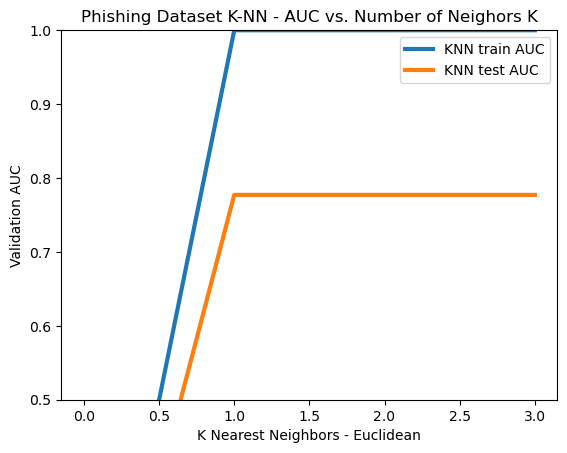

<Figure size 1600x800 with 0 Axes>

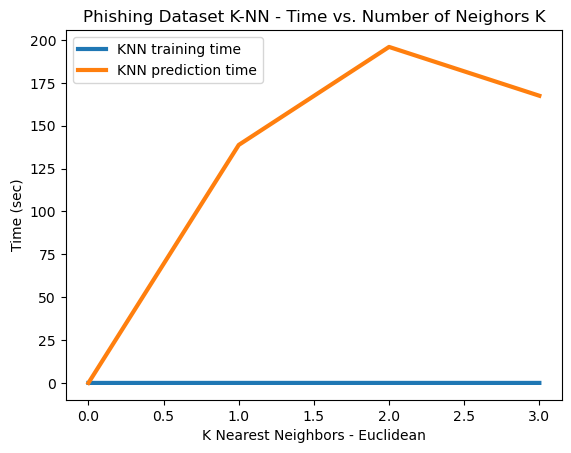

<Figure size 1200x1200 with 0 Axes>

Best number of neighbors training: 1
Highest AUC score training: 0.9998392799742848
Best number of neighbors testing: 1
Highest AUC score testing: 0.7771084337349398


In [11]:
pyplot.plot(knn_auc_train, linewidth=3, label = "KNN train AUC")
pyplot.plot(knn_auc_test, linewidth=3, label = "KNN test AUC")
pyplot.legend()
pyplot.ylim(0.5, 1.0)
pyplot.xlabel("K Nearest Neighbors - Euclidean")
pyplot.ylabel("Validation AUC")
pyplot.title("Phishing Dataset K-NN - AUC vs. Number of Neighors K")
pyplot.figure(figsize=(16,8))
pyplot.savefig('churn_knn_fig6')
pyplot.show()

pyplot.plot(training_time, linewidth=3, label = "KNN training time")
pyplot.plot(prediction_time, linewidth=3, label = "KNN prediction time")
pyplot.legend()
pyplot.xlabel("K Nearest Neighbors - Euclidean")
pyplot.ylabel("Time (sec)")
pyplot.title("Phishing Dataset K-NN - Time vs. Number of Neighors K")
pyplot.figure(figsize=(12,12))
pyplot.savefig('Phishing_Knn_time_fig')
pyplot.show()

print("Best number of neighbors training: " + str(np.argmax(knn_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(knn_auc_train, axis=0)))
print("Best number of neighbors testing: " + str(np.argmax(knn_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(knn_auc_test, axis=0)))

OK


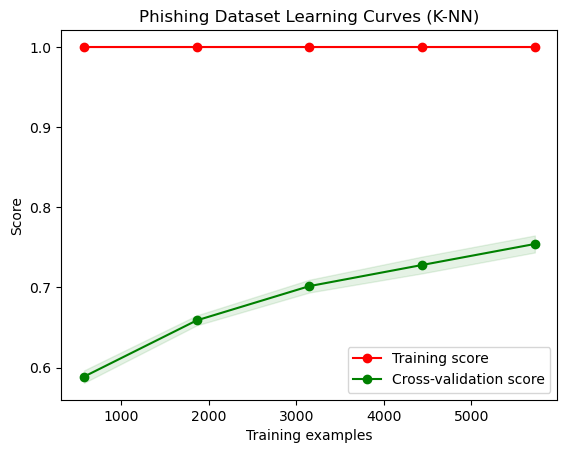

In [13]:
from sklearn.model_selection import learning_curve

X, y = train_X, train_y
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
  
print("OK")


title = "Phishing Dataset Learning Curves (K-NN)"
estimator = KNeighborsClassifier(n_neighbors=1, algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, p=2, weights='uniform')
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)
plt.show()

## Support Vector Machines (SVM)

In [11]:
clf_svm_linear = SVC(kernel='linear',probability=True, random_state=1)
t0 = time.perf_counter()
clf_svm_linear.fit(train_X, train_y)
training_time_linear = round(time.perf_counter()-t0, 3)
pred_train_linear = clf_svm_linear.predict_proba(train_X)[:,1]
t1 = time.perf_counter()
pred_test_linear = clf_svm_linear.predict_proba(test_X)[:,1]
prediction_time_linear = round(time.perf_counter()-t1, 3)
svm_auc_train_linear = roc_auc_score(train_y, pred_train_linear)
svm_auc_test_linear = roc_auc_score(test_y, pred_test_linear)

clf_svm_rbf = SVC(kernel='poly',probability=True, random_state=1)
t0 = time.perf_counter()
clf_svm_rbf.fit(train_X, train_y)
training_time_rbf = round(time.perf_counter() - t0, 3)
pred_train_rbf = clf_svm_rbf.predict_proba(train_X)[:,1]
t1= time.perf_counter()
pred_test_rbf = clf_svm_rbf.predict_proba(test_X)[:,1]
prediction_time_rbf = round(time.perf_counter() - t1, 3)
svm_auc_train_rbf = roc_auc_score(train_y, pred_train_rbf)
svm_auc_test_rbf = roc_auc_score(test_y, pred_test_rbf)

print("Linear kernel training AUC: " + str(svm_auc_train_linear))
print("Linear kernel testing AUC: " + str(svm_auc_test_linear))
print("Poly kernel training AUC: " + str(svm_auc_train_rbf))
print("Poly kernel testing AUC: " + str(svm_auc_test_rbf))

print("Linear kernel training time: " + str(training_time_linear))
print("Linear kernel prediction tim: " + str(prediction_time_linear))
print("Poly kernel training time: " + str(training_time_rbf))
print("Poly kernel prediction tim: " + str(prediction_time_rbf))
                             


Linear kernel training AUC: 0.9999937221844097
Linear kernel testing AUC: 0.9979268352609548
Poly kernel training AUC: 1.0
Poly kernel testing AUC: 0.9986702762105151
Linear kernel training time: 70.862
Linear kernel prediction tim: 7.589
Poly kernel training time: 274.722
Poly kernel prediction tim: 31.623


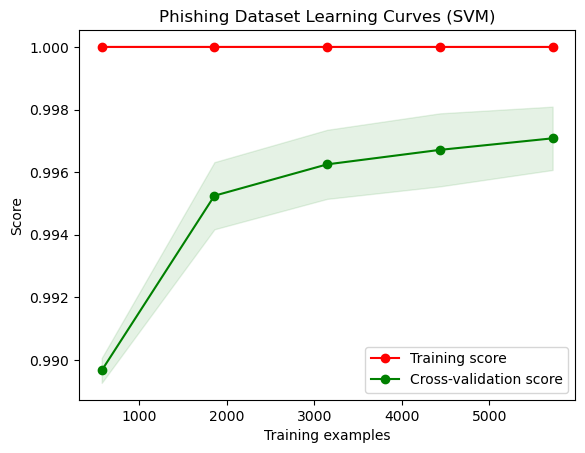

In [12]:
from sklearn.model_selection import learning_curve

X, y = train_X, train_y
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Phishing Dataset Learning Curves (SVM)"
estimator = SVC(kernel='linear',probability=True, random_state=1)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()
